In [1]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import BatchSampler
from sklearn.model_selection import train_test_split
from models import *
from loss import *
from metrics import *
from trainer import *
import numpy as np
import torch
from tqdm import tqdm_notebook

## Prepare Dataset

In [2]:
def loadData(filename):
    data = []
    labels = []
    with open(filename, "r") as f:
        for l in f.readlines():
            l = l.rstrip().split(',')
            example = [float(x) for x in l]
            data.append(example[:-1])
            labels.append(example[-1])
            
    return data, labels

In [3]:
data, labels = loadData('rnn_cluster_data.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=1)

In [5]:
X_train, X_valid, X_test = torch.FloatTensor(X_train), torch.FloatTensor(X_valid), torch.FloatTensor(X_test)
y_train, y_valid, y_test = torch.FloatTensor(y_train), torch.FloatTensor(y_valid), torch.FloatTensor(y_test)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Siamese DataLoader

In [7]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, data, labels, train=False):
        self.data = data
        self.labels = labels
        self.train = train
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {
            label: np.where(self.labels.numpy() == label)[0] for label in self.labels_set
        }
        
        if not self.train:
            random_state = np.random.RandomState(29)

            positive_pairs = [
                [i, random_state.choice(self.label_to_indices[self.labels[i].item()]), 1]
                for i in range(0, len(self.data), 2)
            ]

            negative_pairs = [
                [i, random_state.choice(
                    self.label_to_indices[
                        np.random.choice(
                            list(
                                self.labels_set - set([self.labels[i].item()])
                            )
                        )
                    ]
                ), 0]
                for i in range(1, len(self.data), 2)
            ]
            
            self.test_pairs = positive_pairs + negative_pairs
    
    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            item1, label1 = self.data[index], self.labels[index].item()
            
            if target == 1:
                siamese_label = label1
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
                
            item2 = self.data[siamese_index]
            
        else:
            item1 = self.data[self.test_pairs[index][0]]
            item2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
            
        return (item1, item2), target
    
    def __len__(self):
        return len(self.data)

In [8]:
class BalancedBatchSampler(BatchSampler):
    
    def __init__(self, labels,  n_classes, n_samples):
        self.lables = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {
            label: np.where(self.labels.numpy() == label)[0] for label in self.labels_set
        }
        
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
            
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes
        
    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                    self.used_label_indices_count[class_]:
                    self.used_label_indices_count[class_] + self.n_samples
                ])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
                    
                yield indices
                
                self.count += self.n_classes * self.n_samples
                
    def __len__(self):
        return self.n_dataset

In [9]:
config = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 6,
    'drop_last': True,
    'num_epochs': 400,
    'encode_dim': 1,
    'hidden_dim': 128,
    'output_dim': 2,
    'num_layers': 2,
    'dropout': 0.5,
    'device': device
}

In [10]:
train_set = SiameseNetworkDataset(X_train, y_train, True)
train_loader = DataLoader(
    train_set,
    batch_size=config['batch_size'],
    shuffle=config['shuffle'],
    num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

validation_set = SiameseNetworkDataset(X_valid, y_valid)
validation_loader = DataLoader(
    validation_set,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

test_set = SiameseNetworkDataset(X_test, y_test)
test_loader = DataLoader(
    test_set,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

## Training Siamese Network

In [11]:
RNN_Siamese = RNNSiameseNet(
    config['encode_dim'],
    config['hidden_dim'],
    config['output_dim'],
    config['num_layers'],
    config['dropout']
)

CNN_Siamese = CNNSiameseNet()

In [12]:
import torch.optim as optim

optimizer = optim.Adam(RNN_Siamese.parameters())
criterion = ContrastiveLoss(1.)
metric = binary_accuracy

RNN_Siamese.to(config['device'])
criterion.to(config['device'])

ContrastiveLoss()

In [13]:
writer = SummaryWriter('runs/siamese_rnn/')
loaders = {
    'train': train_loader,
    'valid': validation_loader,
    'test': test_loader
}

In [14]:
fit(RNN_Siamese, loaders, optimizer, criterion, metric, writer, 'rnn-siamese-model.pt', config)

100%|██████████| 400/400 [03:36<00:00,  1.85it/s]


## Extract Embeddings

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings_3d(embeddings, targets, xlim=None, ylim=None, zlim=None):
    plt.figure(figsize=(10,10))
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    for i in range(10):
        inds = np.where(targets==i)[0]
        ax.scatter3D(embeddings[inds,0], embeddings[inds,1], embeddings[inds,2], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if zlim:
        plt.zlim(zlim[0], zlim[1])
    plt.legend(classes)
    
def plot_embeddings_2d(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

    
def extract_embeddings(data, labels, output_dim, model, device):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(data), output_dim))
        targets = np.zeros(len(data))
        for i, (item, label) in enumerate(zip(data, labels)):
            item = item.to(device).view(1, -1)
            embeddings[i] = model.forward_once(item).data.cpu().numpy()
            targets[i] = label.numpy()
    return embeddings, targets

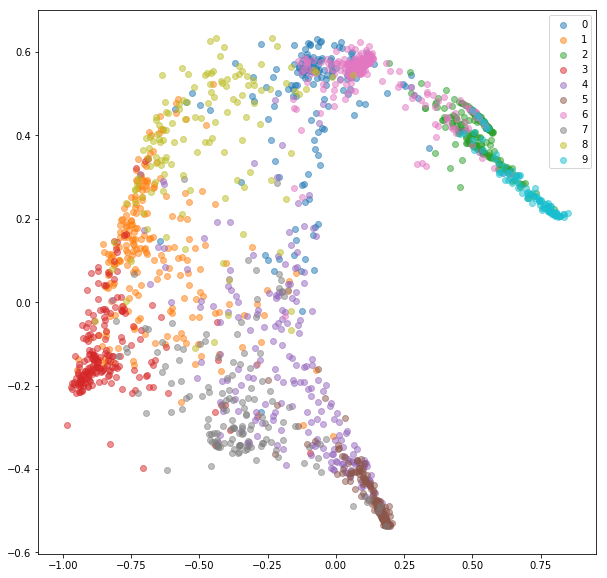

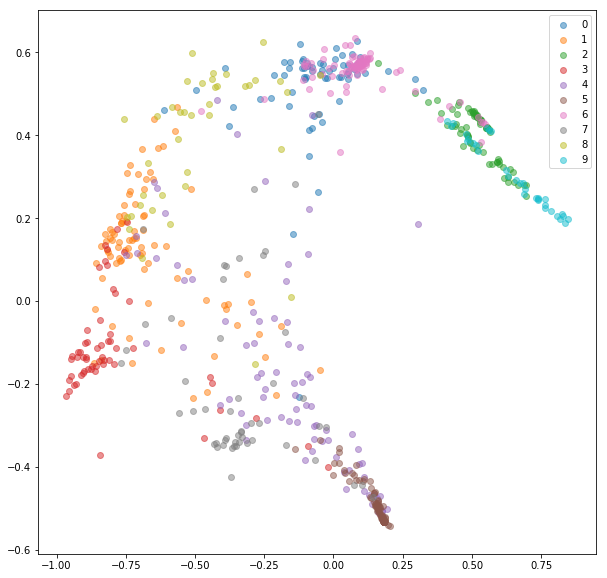

In [18]:
train_embeddings_cl, train_labels_cl = extract_embeddings(X_train, y_train, 2, RNN_Siamese, config['device'])
plot_embeddings_2d(train_embeddings_cl, train_labels_cl)
valid_embeddings_cl, valid_labels_cl = extract_embeddings(X_valid, y_valid, 2, RNN_Siamese, config['device'])
plot_embeddings_2d(valid_embeddings_cl, valid_labels_cl)

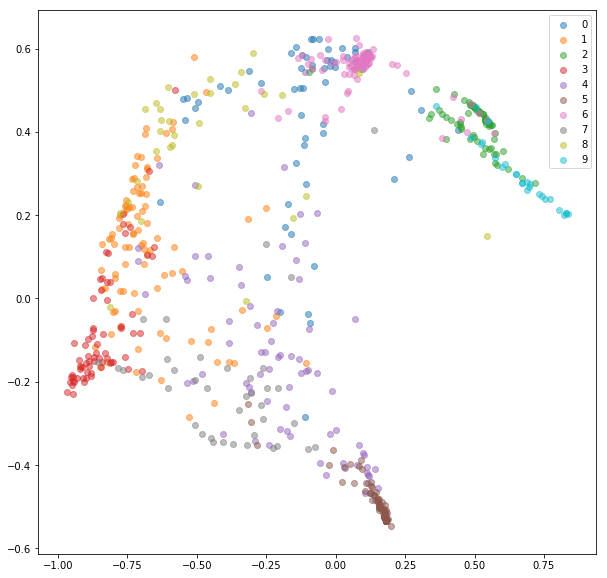

In [19]:
test_embeddings_cl, test_labels_cl = extract_embeddings(X_test, y_test, 2, RNN_Siamese, config['device'])
plot_embeddings_2d(test_embeddings_cl, test_labels_cl)